# CPEN 355 Final Project Fruit Classification
### James Zhang

This notebook explores the investigation of different classification models with tuned hyperparameters for classifying images of fruit from the Fruits-360 dataset from Kaggle https://www.kaggle.com/datasets/moltean/fruits?resource=download.

We start by importing the required libraries and declaring some globals

In [153]:
# The holy trinity of data analysis
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

# Used for data importing
import os
import cv2

# Sklearn imports for model building
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# For hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import sklearn.metrics as metrics

# Extra import for plotting decision region
from mlxtend.plotting import plot_decision_regions

# Globals for importing
TRAIN_PATH = "fruits-360/Training/"
TEST_PATH = "fruits-360/Test/"
FRUITS_TO_CLASSIFY = ["Apple Red 1", "Apple Red 2"]
TRAIN_SAMPLE_SIZE = 200
TEST_SAMPLE_SIZE = 86   # Approximate 70/30 split

# Other globals
N_FOLDS = 5
RANDOM_STATE = 2

The Fruits-360 dataset consists of label-organized images of fruit. We start with a binary classification problem of identifying between two sets of red apples, which are quite visually similar. 

The directories are accessed using `os` and the image data is read using `cv`

In [154]:
def load_images(path:str = TRAIN_PATH, sample_size:int = TRAIN_SAMPLE_SIZE, fruits_to_classify:list = FRUITS_TO_CLASSIFY) -> tuple[np.array, np.array]:

    images = []
    labels = []
    for fruit in os.listdir(path):
        label = fruit.split('/')[-1]
        if label in fruits_to_classify:
            files = os.listdir(path + label)
            num_files = len(files)
            indices = np.linspace(0, num_files - 1, sample_size, dtype=int)
            for index in indices:
                image_path = os.path.join(path + fruit, files[index])
                image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert imread's BGR reading to RGB for image reconstruction
                image = image.flatten()  # Flatten the image into a 1D array
                images.append(image)
                labels.append(label)

    value_map = {"Apple Red 1": 1, "Apple Red 2": 2}
    labels_mapped = pd.Series(labels).map(value_map).values

    images = np.array(images)
    labels = np.array(labels_mapped)
    return images, labels

We load the train and test data and scale them appropriately

In [155]:
X_train, y_train = load_images()
X_test, y_test = load_images(path=TEST_PATH, sample_size=TEST_SAMPLE_SIZE)

To confirm we've preprocessed the images correctly, we plot the recreated image

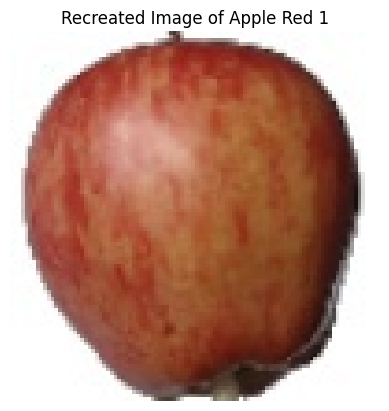

In [156]:
image = X_train[0].reshape(100, 100, 3)
plt.imshow(image)
plt.axis('off')
plt.title('Recreated Image of Apple Red 1')
plt.show()


### Principal Component Analysis

Given the high dimensionality of 2D images, we wish to reduce the dimensionality for computational efficiency, to help avoid the curse of dimensionality, and to help prevent against overfitting. 

In [157]:
# Build PCA with 9 PCs for demonstration purposes
pca = PCA(9)
X_train_pca = pca.fit_transform(X_train)

The first principal component represents the most covariance, with the following principal components representing progressively lower covariance, as displayed in the graph. Additionally, using more principal components allows for better reconstruction of the original data. For building the models, we use 2 PCs.

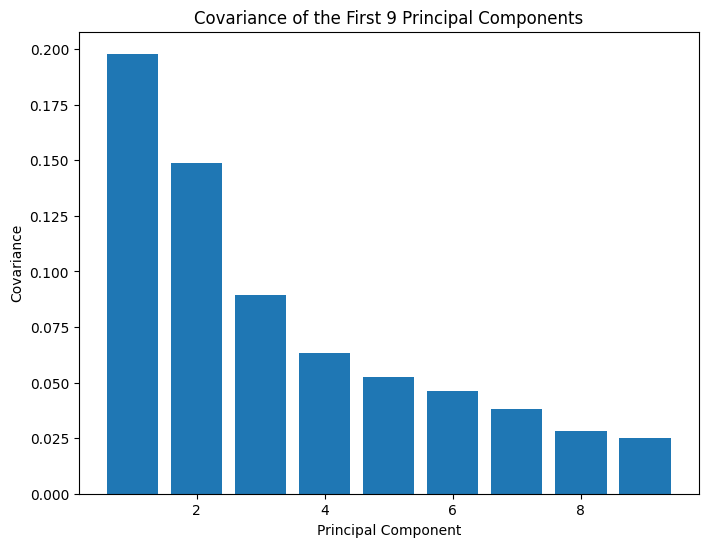

In [158]:
plt.figure(figsize=(8, 6))
plt.bar(range(1, 10), pca.explained_variance_ratio_[:9])
plt.xlabel('Principal Component')
plt.ylabel('Covariance')
plt.title('Covariance of the First 9 Principal Components')
plt.show()

In [159]:
# Re-build PCA with 2 PCs for building models
pca = PCA(2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)  # Transform test data on PCA fitted to training data

### Random Forest Classifier

We start with a random forest classifier for building our classification model, and explore different values for different parameters to identify their effects on bias and variance.

In [160]:
n_trees = [1, 5, 10, 50, 100, 500, 1000]
accuracy_train_list = []
accuracy_test_list = []

for n in n_trees:   # Iterate through different values of # estimators and report accuracy
    rf = RandomForestClassifier(n_estimators=n, random_state=RANDOM_STATE)
    rf.fit(X_train_pca, y_train)
    accuracy_train = rf.score(X_train_pca, y_train)
    accuracy_test = rf.score(X_test_pca, y_test)
    accuracy_train_list.append(accuracy_train)
    accuracy_test_list.append(accuracy_test)
print(accuracy_test_list)


[0.7848837209302325, 0.7674418604651163, 0.7848837209302325, 0.8023255813953488, 0.813953488372093, 0.7965116279069767, 0.7906976744186046]


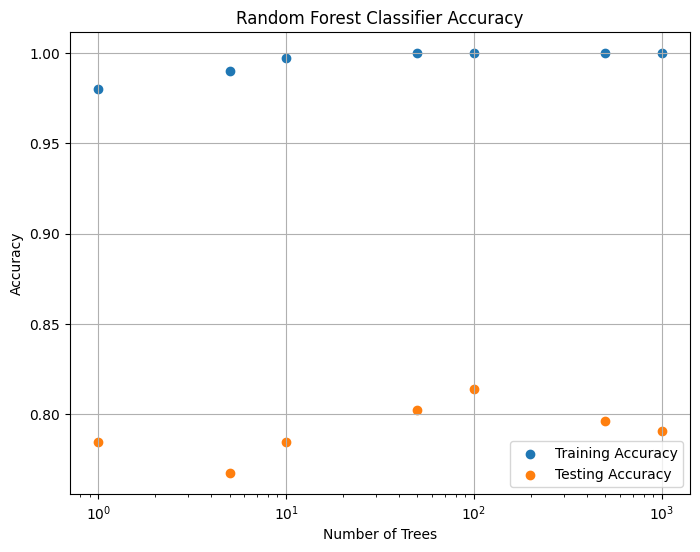

In [161]:
plt.figure(figsize=(8, 6))
plt.scatter(n_trees, accuracy_train_list, marker='o', label='Training Accuracy')
plt.scatter(n_trees, accuracy_test_list, marker='o', label='Testing Accuracy')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Random Forest Classifier Accuracy')
plt.legend()
plt.xscale('log')
plt.grid(True)
plt.show()

With our current data split, we see little change in bias with variable n_estimators. We'll explore this deeper later with k-cross fold validation to find the optimal amount of estimators. We observe a difference between the training and testing accuracy, showing overfitting. We'll attempt to fix this with k-cross fold validation later.

We observe the effects of varying max depth and max leaf nodes

In [162]:
max_depth = [5 , 10, 20, 50, 100]
accuracy_train_list = []
accuracy_test_list = []

for i in max_depth: # Iterate through different values of max depth and report accuracy
    rf = RandomForestClassifier(n_estimators=10, max_depth=i ,random_state=RANDOM_STATE)
    rf.fit(X_train_pca, y_train)
    accuracy_train = rf.score(X_train_pca, y_train)
    accuracy_test = rf.score(X_test_pca, y_test)
    accuracy_train_list.append(accuracy_train)
    accuracy_test_list.append(accuracy_test)

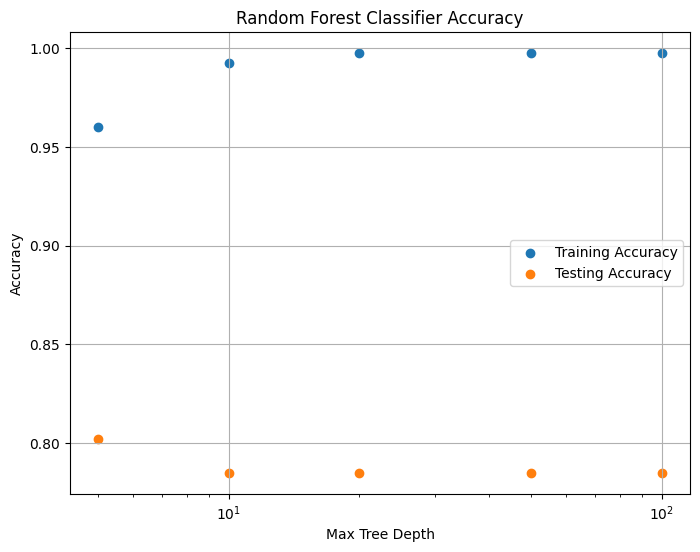

In [163]:
plt.figure(figsize=(8, 6))
plt.scatter(max_depth, accuracy_train_list, marker='o', label='Training Accuracy')
plt.scatter(max_depth, accuracy_test_list, marker='o', label='Testing Accuracy')
plt.xlabel('Max Tree Depth')
plt.ylabel('Accuracy')
plt.title('Random Forest Classifier Accuracy')
plt.legend()
plt.xscale('log')
plt.grid(True)
plt.show()

In [164]:
max_leaf_nodes = [5 , 10, 20, 50, 100]
accuracy_train_list = []
accuracy_test_list = []

for i in max_leaf_nodes:   # Iterate through different values of max leaf nodes and report accuracy
    rf = RandomForestClassifier(n_estimators=10, max_leaf_nodes=i ,random_state=RANDOM_STATE)
    rf.fit(X_train_pca, y_train)
    accuracy_train = rf.score(X_train_pca, y_train)
    accuracy_test = rf.score(X_test_pca, y_test)
    accuracy_train_list.append(accuracy_train)
    accuracy_test_list.append(accuracy_test)

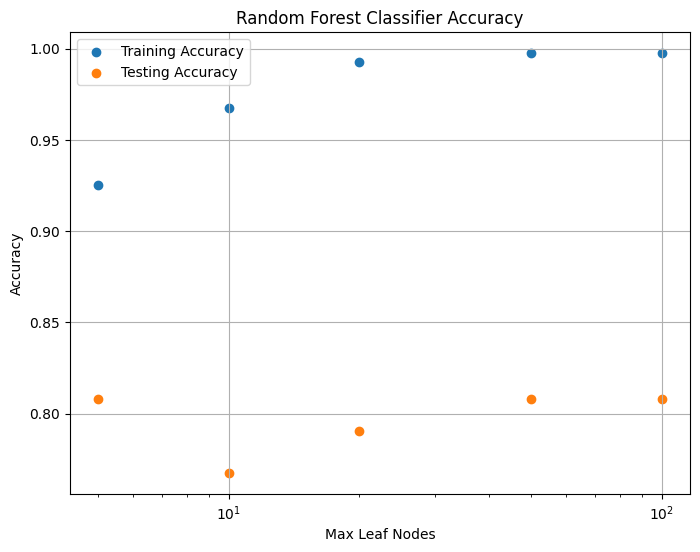

In [165]:
plt.figure(figsize=(8, 6))
plt.scatter(max_leaf_nodes, accuracy_train_list, marker='o', label='Training Accuracy')
plt.scatter(max_leaf_nodes, accuracy_test_list, marker='o', label='Testing Accuracy')
plt.xlabel('Max Leaf Nodes')
plt.ylabel('Accuracy')
plt.title('Random Forest Classifier Accuracy')
plt.legend()
plt.xscale('log')
plt.grid(True)
plt.show()

We observe increasing the number of max leaf nodes increases the accuracy. 

We similarly observe for both tree depth and leaf nodes that overfitting occurs.

### Linear Kernel SVM

We now investigate the accuracies of a linear kernnel SVM fitted on the same data with varying values of C

In [166]:
Cs = [0.00000000001, 0.0000001, 0.00001, 0.001, 0.01, 1, 100, 1000, 100000, 1000000000]
accuracies = []
for c in Cs: # Create, fit, and score Linear Kernel SVC for varying values of C   
    svc = LinearSVC(random_state=RANDOM_STATE, C=c, dual=False, max_iter=10000)
    svc.fit(X_train_pca, y_train)
    accuracy = svc.score(X_test_pca, y_test)
    accuracies.append(accuracy)

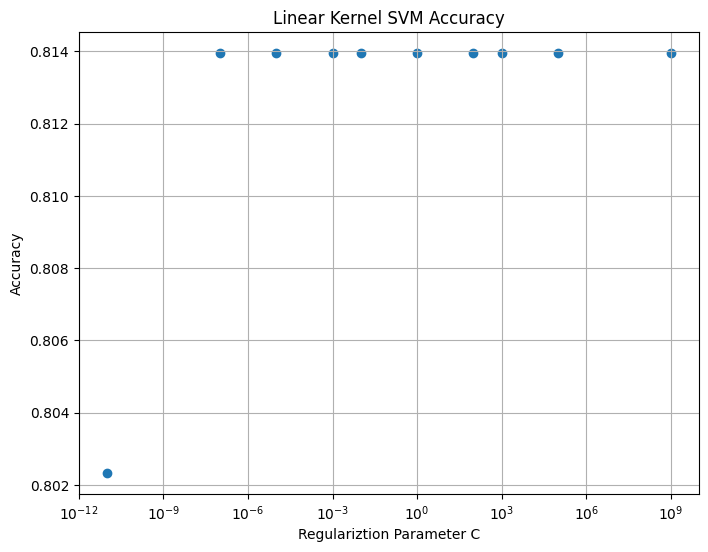

In [167]:
plt.figure(figsize=(8, 6))
plt.scatter(Cs, accuracies, marker='o')
plt.xlabel('Regulariztion Parameter C')
plt.ylabel('Accuracy')
plt.title('Linear Kernel SVM Accuracy')
plt.xscale('log')
plt.grid(True)
plt.show()

We observe the accuracy doesn't change much with different values of C. We'll explore optimizing the value of C in k-fold cross validation later.

### K-Nearest Neighbor 

We now investigate the accuracies of a KNN model fitted on the same data with varying values of neighbors.

In [168]:
k_values = [1, 3, 5, 7, 9, 11, 13, 15]
accuracies = []
for k in k_values:  # Create, fit, and score KNN for varying values of k  
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_pca, y_train)
    accuracy = knn.score(X_test_pca, y_test)
    accuracies.append(accuracy)

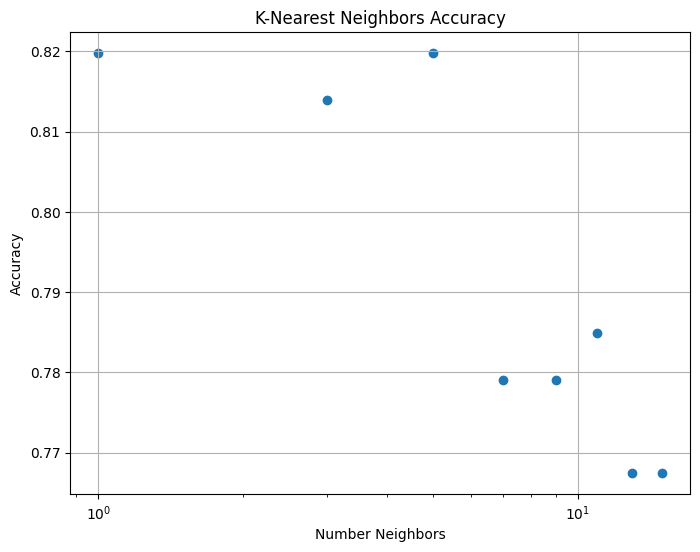

In [169]:
plt.figure(figsize=(8, 6))
plt.scatter(k_values, accuracies, marker='o')
plt.xlabel('Number Neighbors')
plt.ylabel('Accuracy')
plt.title('K-Nearest Neighbors Accuracy')
plt.xscale('log')
plt.grid(True)
plt.show()

We observe varying accuracy and will optimize the number of neighbors in k-fold cross validation.

### K-Fold Cross Validation

We perform grid search to optimize the value of C for the LSVC, the number of estimators for the random forest, and the number of neighbors for the KNN model.

In [170]:
cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=2)

space_lsvc = {'C' : [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
space_rf = {'n_estimators' : [1, 10, 50, 100, 500, 1000]}
space_knn = {'n_neighbors' : [1, 3, 5, 7, 9, 11, 13, 15]}

grid_lsvc = GridSearchCV(estimator = svc, param_grid = space_lsvc, cv=cv, scoring='accuracy')
grid_rf = GridSearchCV(estimator = rf, param_grid = space_rf, cv=cv, scoring='accuracy')
grid_knn = GridSearchCV(estimator = knn, param_grid = space_knn, cv=cv, scoring='accuracy')

grid_lsvc.fit(X_train_pca, y_train)
grid_rf.fit(X_train_pca, y_train)
grid_knn.fit(X_train_pca, y_train)

# Extracting the optimized hyperparameters and corresponding accuracies
best_lsvc = grid_lsvc.best_estimator_
lsvc_yhat = best_lsvc.predict(X_test_pca)
best_rf = grid_rf.best_estimator_
rf_yhat = best_rf.predict(X_test_pca)
best_knn = grid_knn.best_estimator_
knn_yhat = best_knn.predict(X_test_pca)

print("Optimal C for linear kernel SVM: ", grid_lsvc.best_params_)
print("Optimal hyperparameters for random forest: ", grid_rf.best_params_)
print("Optimal hyperparameters for KNN: ", grid_knn.best_params_)

Optimal C for linear kernel SVM:  {'C': 1e-05}
Optimal hyperparameters for random forest:  {'n_estimators': 1000}
Optimal hyperparameters for KNN:  {'n_neighbors': 7}


In [171]:
lsvc_accuracy = metrics.accuracy_score(y_test, lsvc_yhat) * 100
rf_accuracy = metrics.accuracy_score(y_test, rf_yhat) * 100
knn_accuracy = metrics.accuracy_score(y_test, knn_yhat) * 100

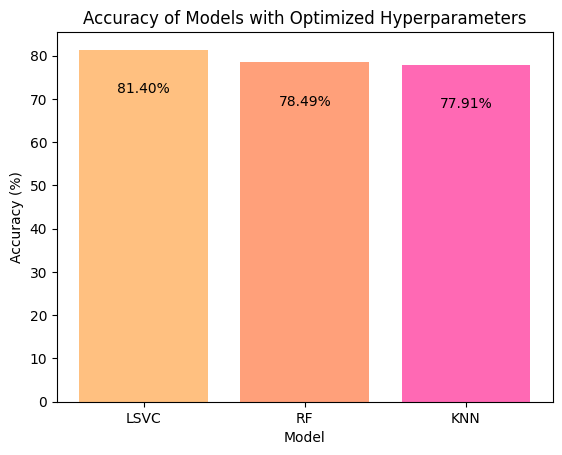

In [172]:
fig, ax = plt.subplots()
ax.bar("LSVC", lsvc_accuracy, color='#FFC080') 
ax.bar("RF", rf_accuracy, color='#FFA07A') 
ax.bar("KNN", knn_accuracy, color='#FF69B4')
ax.text("LSVC", lsvc_accuracy - 10, "{:.2f}%".format(lsvc_accuracy), ha="center")
ax.text("RF", rf_accuracy - 10, "{:.2f}%".format(rf_accuracy), ha="center")
ax.text("KNN", knn_accuracy - 10, "{:.2f}%".format(knn_accuracy), ha="center")
ax.set_title("Accuracy of Models with Optimized Hyperparameters")
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Model")
plt.show()

We observe that LSVC with a C value of 1e-05 gives the best accuracy. To see if we've dealt with overfitting, we plot the training and testing accuracy.

In [173]:
lsvc_yhat = best_lsvc.predict(X_train_pca)
lsvc_train_accuracy = metrics.accuracy_score(y_train, lsvc_yhat) * 100

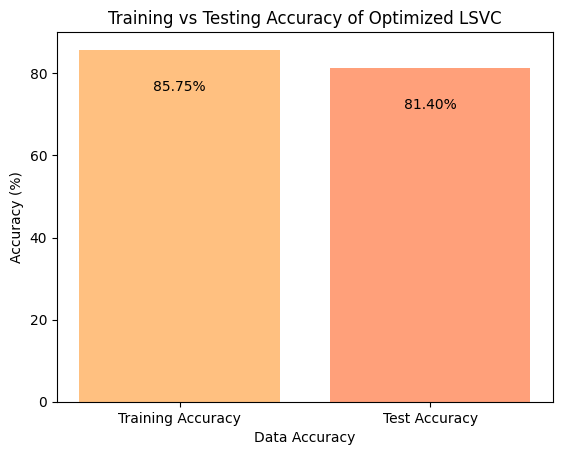

In [174]:
fig, ax = plt.subplots()
ax.bar("Training Accuracy", lsvc_train_accuracy, color='#FFC080') 
ax.bar("Test Accuracy", lsvc_accuracy, color='#FFA07A') 
ax.text("Training Accuracy", lsvc_train_accuracy - 10, "{:.2f}%".format(lsvc_train_accuracy), ha="center")
ax.text("Test Accuracy", lsvc_accuracy - 10, "{:.2f}%".format(lsvc_accuracy), ha="center")
ax.set_title("Training vs Testing Accuracy of Optimized LSVC")
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Data Accuracy")
plt.show()

We observe a 4.3% difference between the accuarcies, significantly smaller than the ~20% difference observed with varying number of trees for the random forest model.

## Extras

### Increasing Principal Components

Let's try increasing the number of PCs and observe the reconstructed image and the effect on the LSVC's accuracy

In [175]:
# Reconstruct the original image from the preprocessed data
image_shape = (100, 100, 3)
original_image = X_train[0].reshape(image_shape)

# Reconstruct the image using the PCA fitted with 2 PCs
reconstructed_image = pca.inverse_transform(X_train_pca[0].reshape(1, -1))
reconstructed2pc = reconstructed_image.reshape(image_shape)

In [176]:
# Repeat image reconstruction with increasing amount of PCs
pca = PCA(10)
X_train_pca = pca.fit_transform(X_train)
reconstructed_image = pca.inverse_transform(X_train_pca[0].reshape(1, -1))
reconstructed10pc = reconstructed_image.reshape(image_shape)

pca = PCA(50)
X_train_pca = pca.fit_transform(X_train)
reconstructed_image = pca.inverse_transform(X_train_pca[0].reshape(1, -1))
reconstructed50pc = reconstructed_image.reshape(image_shape)

pca = PCA(200)
X_train_pca = pca.fit_transform(X_train)
reconstructed_image = pca.inverse_transform(X_train_pca[0].reshape(1, -1))
reconstructed200pc = reconstructed_image.reshape(image_shape)


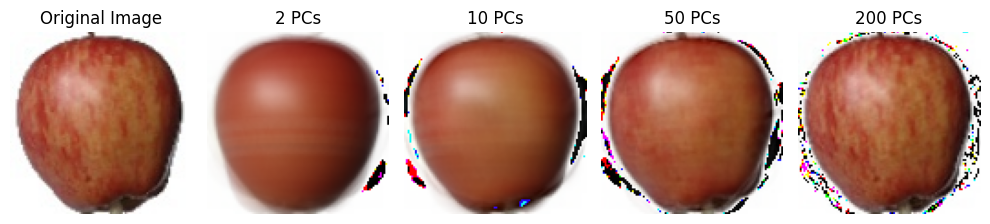

In [177]:
# Create plot with 5 subplots for 5 image reconstructions

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(10, 5))

ax1.imshow(original_image.astype(np.uint8))
ax1.set_title('Original Image')
ax1.axis('off')

ax2.imshow(reconstructed2pc.astype(np.uint8))
ax2.set_title('2 PCs')
ax2.axis('off')

ax3.imshow(reconstructed10pc.astype(np.uint8))
ax3.set_title('10 PCs')
ax3.axis('off')

ax4.imshow(reconstructed50pc.astype(np.uint8))
ax4.set_title('50 PCs')
ax4.axis('off')

ax5.imshow(reconstructed200pc.astype(np.uint8))
ax5.set_title('200 PCs')
ax5.axis('off')

plt.tight_layout()
plt.show()

In [178]:
# Fit GridSearchCV with X data transformed with 200 PCs
grid_lsvc.fit(X_train_pca, y_train)
best_lsvc = grid_lsvc.best_estimator_

# Transform test data with 200 PCs PCA and score accuracy
X_test_pca = pca.transform(X_test)
yhat = best_lsvc.predict(X_test_pca)
accuracy = metrics.accuracy_score(y_test, yhat) * 100

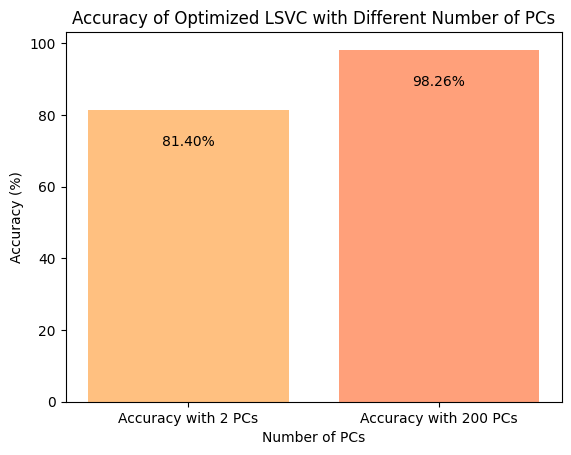

In [179]:
fig, ax = plt.subplots()
ax.bar("Accuracy with 2 PCs", lsvc_accuracy, color='#FFC080') 
ax.bar("Accuracy with 200 PCs", accuracy, color='#FFA07A') 
ax.text("Accuracy with 2 PCs", lsvc_accuracy - 10, "{:.2f}%".format(lsvc_accuracy), ha="center")
ax.text("Accuracy with 200 PCs", accuracy - 10, "{:.2f}%".format(accuracy), ha="center")
ax.set_title("Accuracy of Optimized LSVC with Different Number of PCs")
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Number of PCs")
plt.show()

We see that increasing the number of PCs increases the accuracy of the reconstructed image, and the accuracy of the optimized LSVC model.

### Multi-Class Classifcation

Let's try classifying 5 different fruits

In [180]:
FRUITS_TO_CLASSIFY = ["Cherry 1", "Lychee", "Mango", "Pineapple", "Watermelon"]

In [181]:
def load_images(path:str = TRAIN_PATH, sample_size:int = TRAIN_SAMPLE_SIZE, fruits_to_classify:list = FRUITS_TO_CLASSIFY) -> tuple[np.array, np.array]:

    images = []
    labels = []
    for fruit in os.listdir(path):
        label = fruit.split('/')[-1]
        if label in fruits_to_classify:
            files = os.listdir(path + label)
            num_files = len(files)
            indices = np.linspace(0, num_files - 1, sample_size, dtype=int)
            for index in indices:
                image_path = os.path.join(path + fruit, files[index])
                image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert imread's BGR reading to RGB for image reconstruction
                image = image.flatten()  # Flatten the image into a 1D array
                images.append(image)
                labels.append(label)

    value_map = {"Cherry 1" : 1, "Lychee" : 2, "Mango" : 3, "Pineapple" : 4, "Watermelon" : 5}  # Changed for 5 fruits
    labels_mapped = pd.Series(labels).map(value_map).values

    images = np.array(images)
    labels = np.array(labels_mapped)
    return images, labels

X_train, y_train = load_images()
X_test, y_test = load_images(path=TEST_PATH, sample_size=TEST_SAMPLE_SIZE)

In [182]:
# Transform data with 200 PCs PCA
pca = PCA(200)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test) 

In [183]:
# Fit Grid search with transformed data
grid_lsvc.fit(X_train_pca, y_train)
best_lsvc = grid_lsvc.best_estimator_

# Score accuracy
X_test_pca = pca.transform(X_test)
yhat = best_lsvc.predict(X_test_pca)
print(f"Accuracy of Multi-Class Classification Model: {int(metrics.accuracy_score(y_test, yhat) * 100)}%")

Accuracy of Multi-Class Classification Model: 100%


We see that the accuracy of the model increases to 100% with multi-class classifcation. This is expected as the 5 fruits have more distinguishing characteristics.

### Identifying Fruits Generated by Meta AI

The model is very accurate at identifying images from a standardized set. Let's test the accuracy with AI generated images of fruit.

In [184]:
EMU_PATH = "emu/"
EMU_SAMPLE_SIZE = 4

In [185]:
def load_images(path:str = TRAIN_PATH, sample_size:int = TRAIN_SAMPLE_SIZE, fruits_to_classify:list = FRUITS_TO_CLASSIFY) -> tuple[np.array, np.array]:

    images = []
    labels = []
    for fruit in os.listdir(path):
        label = fruit.split('/')[-1]
        if label in fruits_to_classify:
            files = os.listdir(path + label)
            num_files = len(files)
            indices = np.linspace(0, num_files - 1, sample_size, dtype=int)
            for index in indices:
                image_path = os.path.join(path + fruit, files[index])
                image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert imread's BGR reading to RGB for image reconstruction
                image = cv2.resize(image, (100, 100))
                image = image.flatten()  # Flatten the image into a 1D array
                images.append(image)
                labels.append(label)

    value_map = {"Cherry 1" : 1, "Lychee" : 2, "Mango" : 3, "Pineapple" : 4, "Watermelon" : 5}
    labels_mapped = pd.Series(labels).map(value_map).values

    images = np.array(images)
    labels = np.array(labels_mapped)
    return images, labels

X_emu, y_emu = load_images(path=EMU_PATH, sample_size=EMU_SAMPLE_SIZE)

In [186]:
# Build the 
X_emu_pca = pca.transform(X_emu)
yhat_emu = best_lsvc.predict(X_emu_pca)
print(f"Accuracy of Multi-Class Classification Model: {int(metrics.accuracy_score(y_emu, yhat_emu) * 100)}%")

Accuracy of Multi-Class Classification Model: 20%


c:\Users\james\OneDrive - UBC\Desktop\Final Project\FinalProject_James\.fruit\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\james\OneDrive - UBC\Desktop\Final Project\FinalProject_James\.fruit\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\james\OneDrive - UBC\Desktop\Final Project\FinalProject_James\.fruit\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

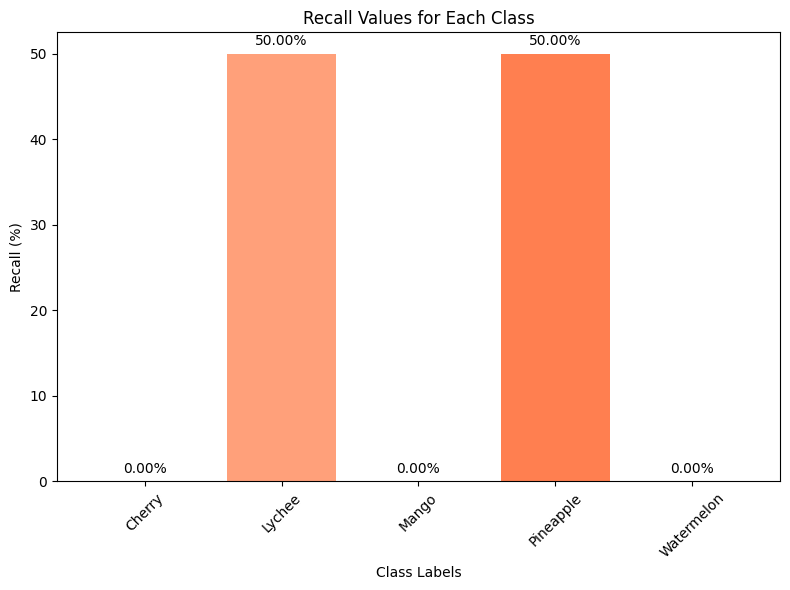

In [187]:
from sklearn.metrics import classification_report
report = classification_report(y_emu, yhat_emu, output_dict=True)

value_map = {"Cherry": 1, "Lychee": 2, "Mango": 3, "Pineapple": 4, "Watermelon": 5}
labels = list(value_map.keys())
recall_values = [report[str(value_map[label])]['recall'] * 100 for label in labels] 

fig, ax = plt.subplots(figsize=(8, 6))

colors = ['#FFC080', '#FFA07A', '#FF8C69', '#FF7F50', '#FF6347']

for i, (label, recall) in enumerate(zip(labels, recall_values)):
    ax.bar(label, recall, color=colors[i])
    ax.text(label, recall + 1, "{:.2f}%".format(recall), ha="center")

ax.set_title("Recall Values for Each Class")
ax.set_ylabel("Recall (%)")
ax.set_xlabel("Class Labels")
plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()

We observe low recall values for cherries, mangoes, and watermelon. This is because in the generated pictures, the cherry takes up a small portion of the picture, the mango and cherry have different levels of ripeness, and the watermelons are cut open. Half the lychee pictures include both the lychee shell and flesh. The pineapple pictures are generally the same ripeness, and only in one picture is the pineapple cut open.